# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from hw2code import DecisionTree
from collections import Counter
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
import copy

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [8]:
from sklearn.datasets import make_moons, make_circles, make_classification
dataset1 = make_circles(noise=0.2, factor=0.5, random_state=42)
dataset2 = make_moons(noise=0.2, random_state=42)
dataset3 = make_classification(
    n_classes=3, 
    n_clusters_per_class=1, 
    n_features=2, 
    class_sep=0.8, 
    random_state=3,
    n_redundant=0,
    n_informative=2
)

datasets = [dataset1, dataset2, dataset3]

In [9]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

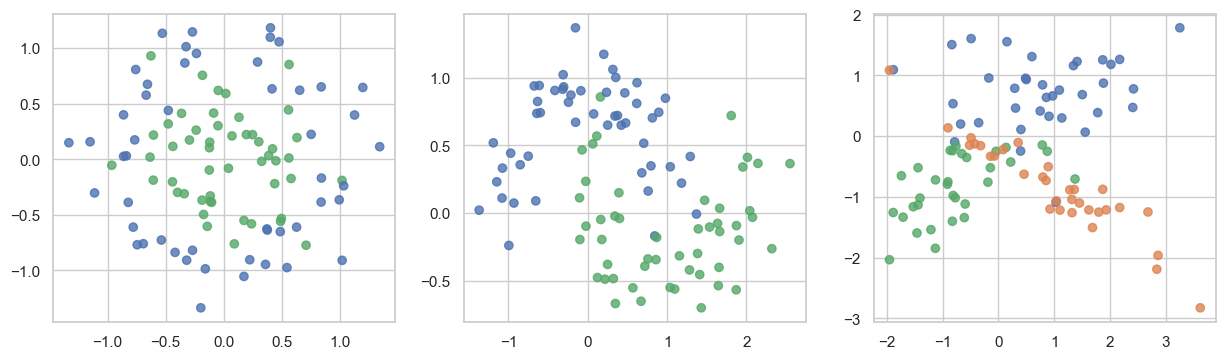

In [10]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [11]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

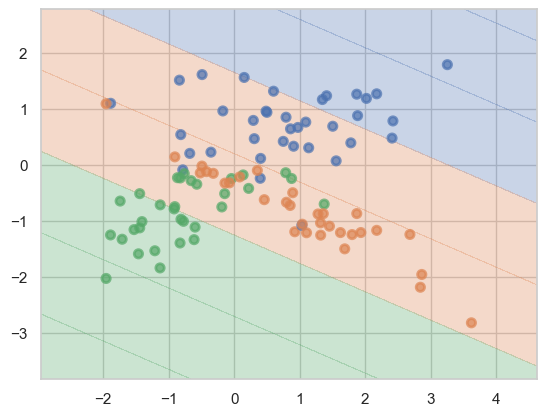

In [13]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

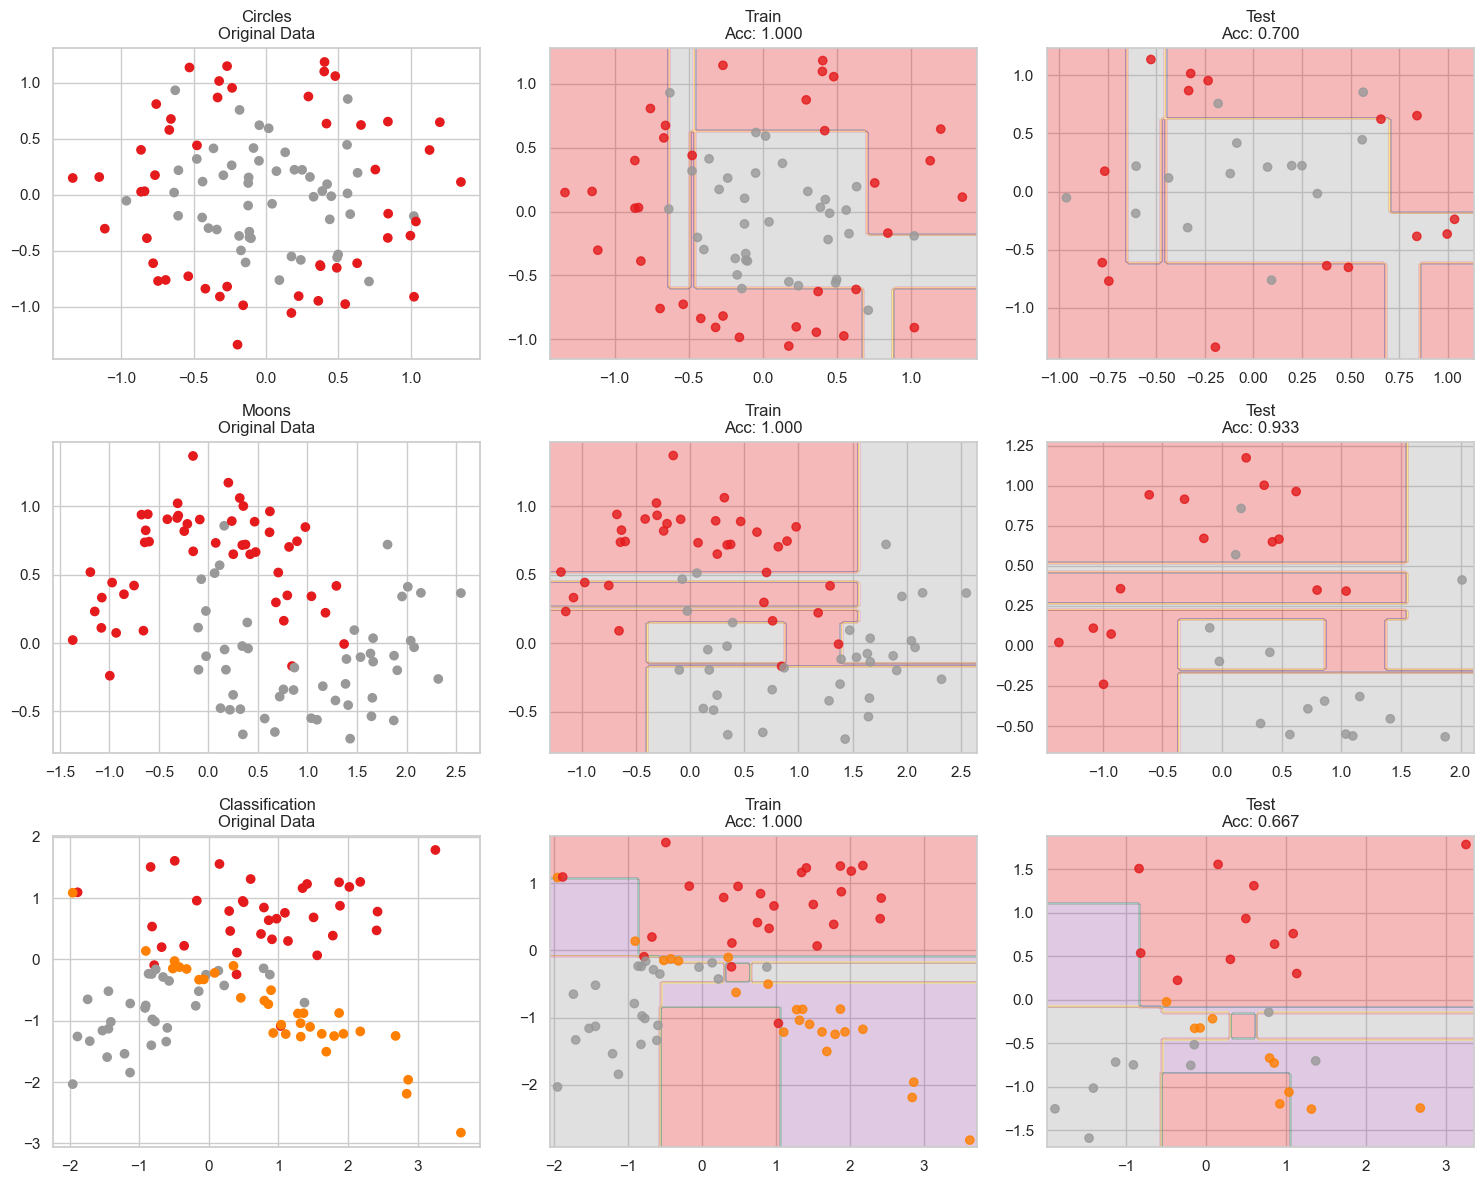

Результаты анализа переобучения:
Circles         | Train: 1.000 | Test: 0.700 | Overfit: 0.300 | Сильное переобучение
Moons           | Train: 1.000 | Test: 0.933 | Overfit: 0.067 | Стабильно
Classification  | Train: 1.000 | Test: 0.667 | Overfit: 0.333 | Сильное переобучение

Время выполнения: 3.06 сек


In [33]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.metrics import accuracy_score
import time

def plot_decision_surface(clf, X, y, ax):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, alpha=0.8)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

start_time = time.time()

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
dataset_names = ['Circles', 'Moons', 'Classification']
results_data = []

for idx, (X_data, y_data) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.3, random_state=42, stratify=y_data
    )
    
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(X_train, y_train)
    
    train_accuracy = classifier.score(X_train, y_train)
    test_accuracy = classifier.score(X_test, y_test)
    
    results_data.append({
        'dataset': dataset_names[idx],
        'train_acc': train_accuracy,
        'test_acc': test_accuracy,
        'overfitting': train_accuracy - test_accuracy
    })
    
    axes[idx, 0].scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap=plt.cm.Set1)
    axes[idx, 0].set_title(f'{dataset_names[idx]}\nOriginal Data')
    
    plot_decision_surface(classifier, X_train, y_train, axes[idx, 1])
    axes[idx, 1].set_title(f'Train\nAcc: {train_accuracy:.3f}')
    
    plot_decision_surface(classifier, X_test, y_test, axes[idx, 2])
    axes[idx, 2].set_title(f'Test\nAcc: {test_accuracy:.3f}')

plt.tight_layout()
plt.show()

execution_time = time.time() - start_time

print("Результаты анализа переобучения:")
print("=" * 50)
for result in results_data:
    status = "Сильное переобучение" if result['overfitting'] > 0.1 else "Стабильно"
    print(f"{result['dataset']:15} | Train: {result['train_acc']:.3f} | Test: {result['test_acc']:.3f} | Overfit: {result['overfitting']:.3f} | {status}")

print(f"\nВремя выполнения: {execution_time:.2f} сек")

__Ответ:__Деревья с параметрами по умолчанию демонстрируют сильное переобучение на двух из трех датасетов.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?


Circles:
--------------------------------------------------
max_depth=2   , min_samples_leaf= 1 | Train: 0.829, Test: 0.633 | Overfit: 0.195 | ПЕРЕОБУЧЕНИЕ
max_depth=2   , min_samples_leaf= 5 | Train: 0.814, Test: 0.667 | Overfit: 0.148 | ПЕРЕОБУЧЕНИЕ
max_depth=2   , min_samples_leaf=10 | Train: 0.814, Test: 0.667 | Overfit: 0.148 | ПЕРЕОБУЧЕНИЕ
max_depth=5   , min_samples_leaf= 1 | Train: 0.971, Test: 0.767 | Overfit: 0.205 | ПЕРЕОБУЧЕНИЕ
max_depth=5   , min_samples_leaf= 5 | Train: 0.871, Test: 0.900 | Overfit: -0.029 | СТАБИЛЬНО
max_depth=5   , min_samples_leaf=10 | Train: 0.814, Test: 0.767 | Overfit: 0.048 | СТАБИЛЬНО
max_depth=10  , min_samples_leaf= 1 | Train: 1.000, Test: 0.733 | Overfit: 0.267 | ПЕРЕОБУЧЕНИЕ
max_depth=10  , min_samples_leaf= 5 | Train: 0.871, Test: 0.900 | Overfit: -0.029 | СТАБИЛЬНО
max_depth=10  , min_samples_leaf=10 | Train: 0.814, Test: 0.767 | Overfit: 0.048 | СТАБИЛЬНО
max_depth=None, min_samples_leaf= 1 | Train: 1.000, Test: 0.733 | Overfit: 0.267 | ПЕ

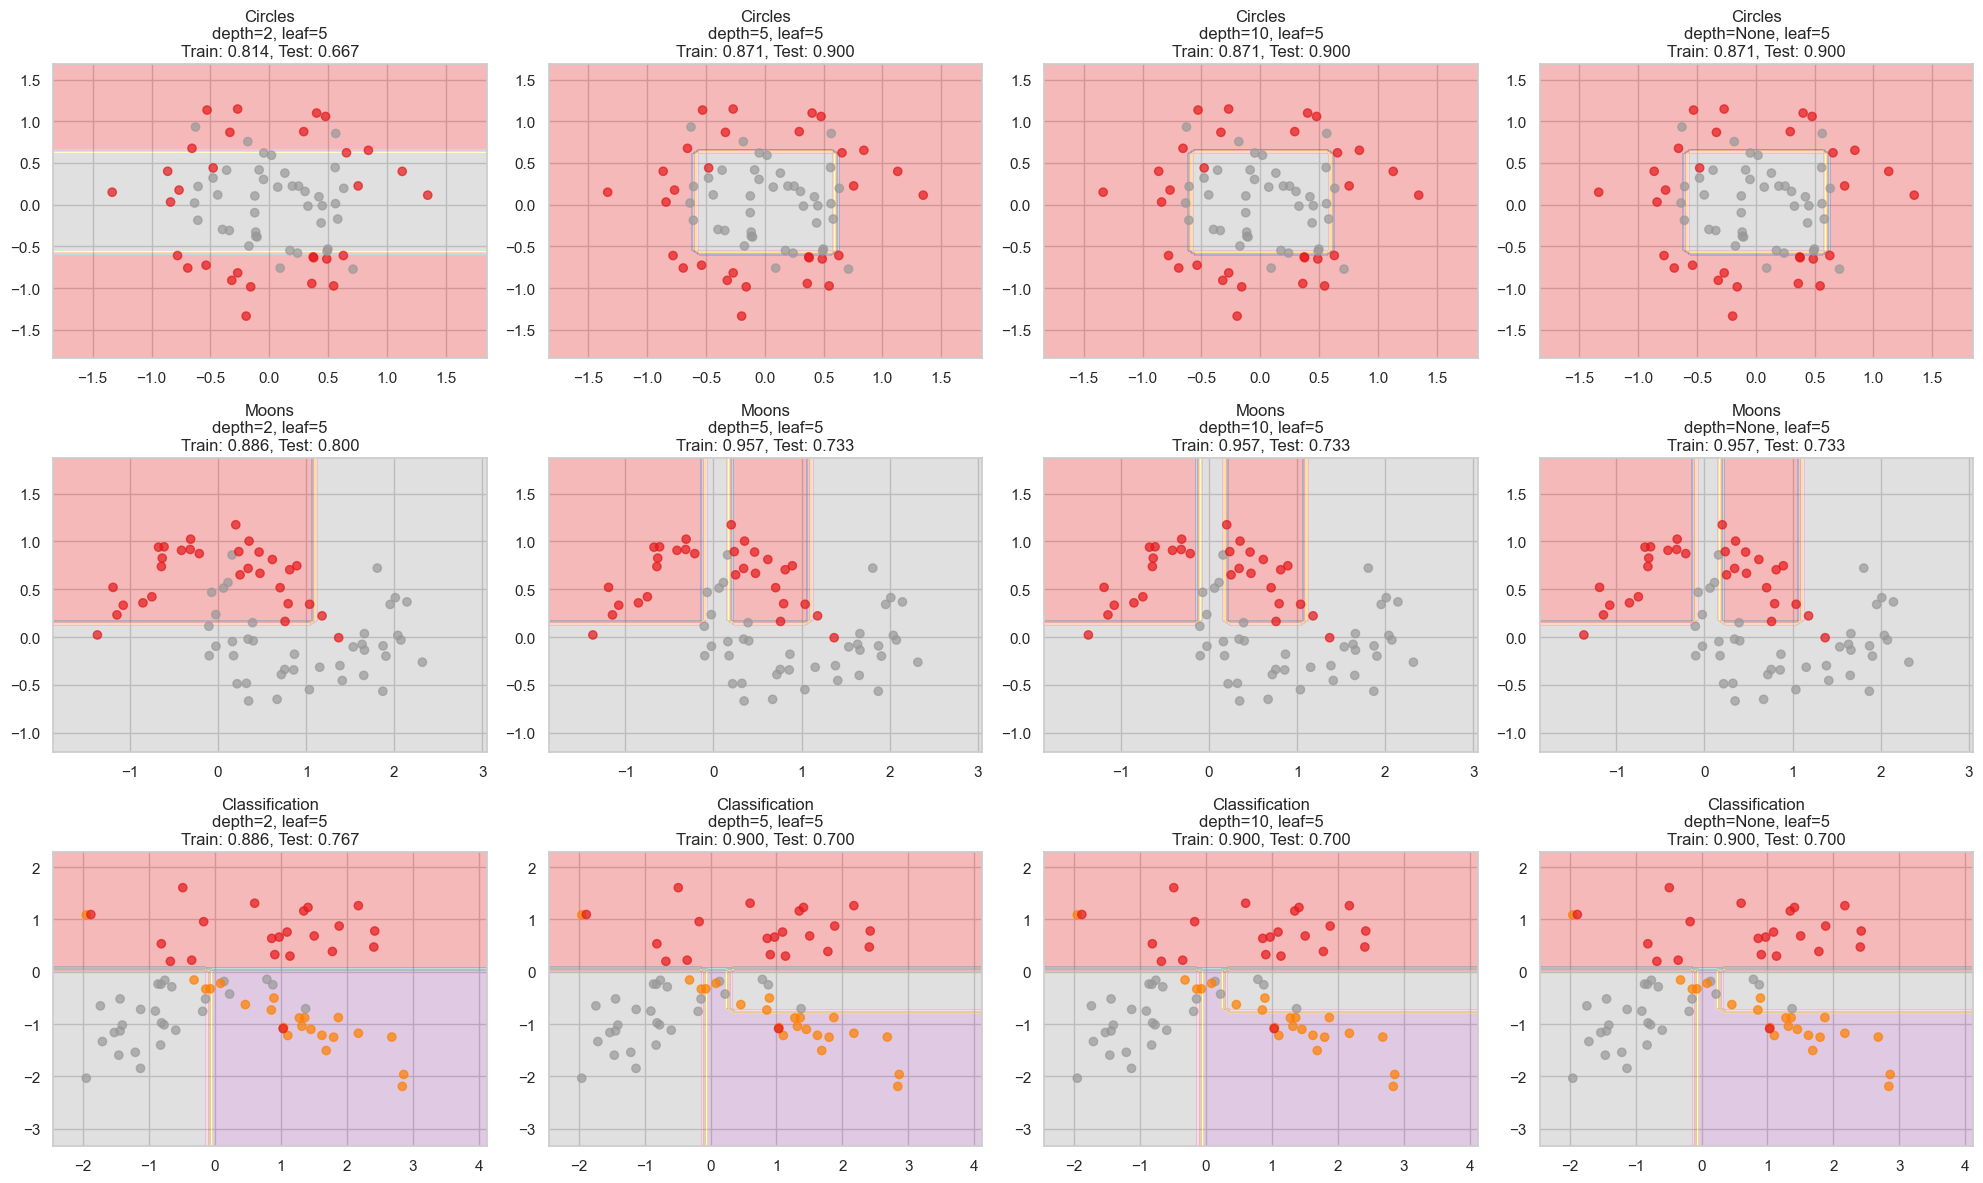

In [37]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
max_depth_values = [2, 5, 10, None]
min_samples_leaf_values = [1, 5, 10]

fig, axes = plt.subplots(len(datasets), len(max_depth_values), figsize=(20, 12))
dataset_names = ['Circles', 'Moons', 'Classification']

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    print(f"\n{dataset_names[i]}:")
    print("-" * 50)
    
    for j, max_depth in enumerate(max_depth_values):
        for min_samples_leaf in min_samples_leaf_values:
            dt = DecisionTreeClassifier(
                max_depth=max_depth, 
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
            dt.fit(X_train, y_train)
            
            train_acc = accuracy_score(y_train, dt.predict(X_train))
            test_acc = accuracy_score(y_test, dt.predict(X_test))
            
            depth_str = "None" if max_depth is None else str(max_depth)
            overfitting = train_acc - test_acc
            status = "ПЕРЕОБУЧЕНИЕ" if overfitting > 0.1 else "СТАБИЛЬНО"
            
            print(f"max_depth={depth_str:4}, min_samples_leaf={min_samples_leaf:2} | "
                  f"Train: {train_acc:.3f}, Test: {test_acc:.3f} | "
                  f"Overfit: {overfitting:.3f} | {status}")
            
            if min_samples_leaf == 5:
                x_min, x_max = X[:, 0].min()-0.5, X[:, 0].max()+0.5
                y_min, y_max = X[:, 1].min()-0.5, X[:, 1].max()+0.5
                xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                                    np.linspace(y_min, y_max, 50))
                
                Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                
                axes[i, j].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
                axes[i, j].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Set1, alpha=0.7)
                
                axes[i, j].set_title(f'{dataset_names[i]}\ndepth={depth_str}, leaf=5\nTrain: {train_acc:.3f}, Test: {test_acc:.3f}')

plt.tight_layout()
plt.show()



__Ответ:__Эксперимент показывает, что оптимальные гиперпараметры сильно зависят от структуры данных. Чем больше глубина дерева, тем сильнее переобучение. При max_depth=None точность на обучении 100%, но на тесте хуже. При max_depth=2 переобучение меньше, но и точность ниже. Параметр min_samples_leaf тоже помогает бороться с переобучением - чем он больше, тем стабильнее результаты. Для каждого датасета нужно подбирать свои параметры.


# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

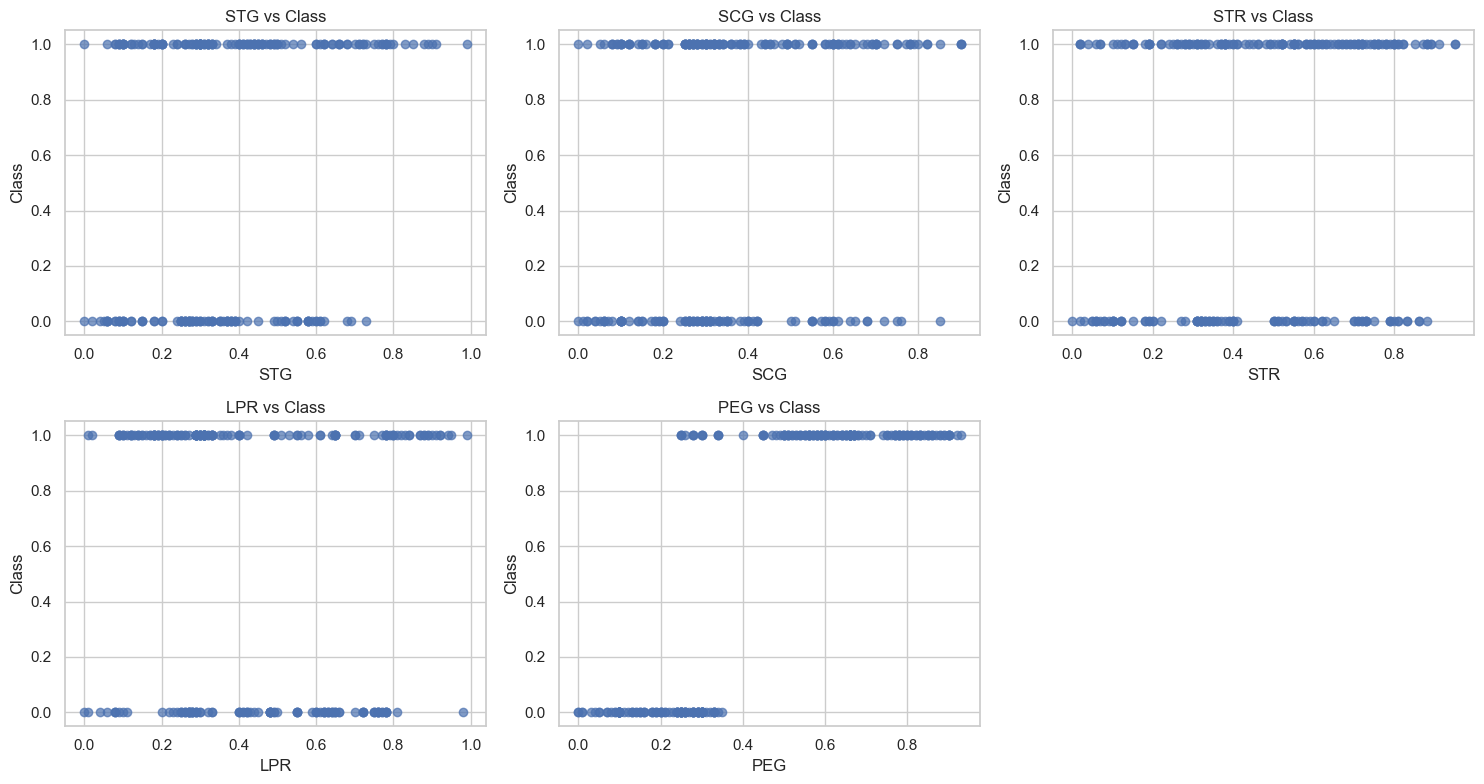

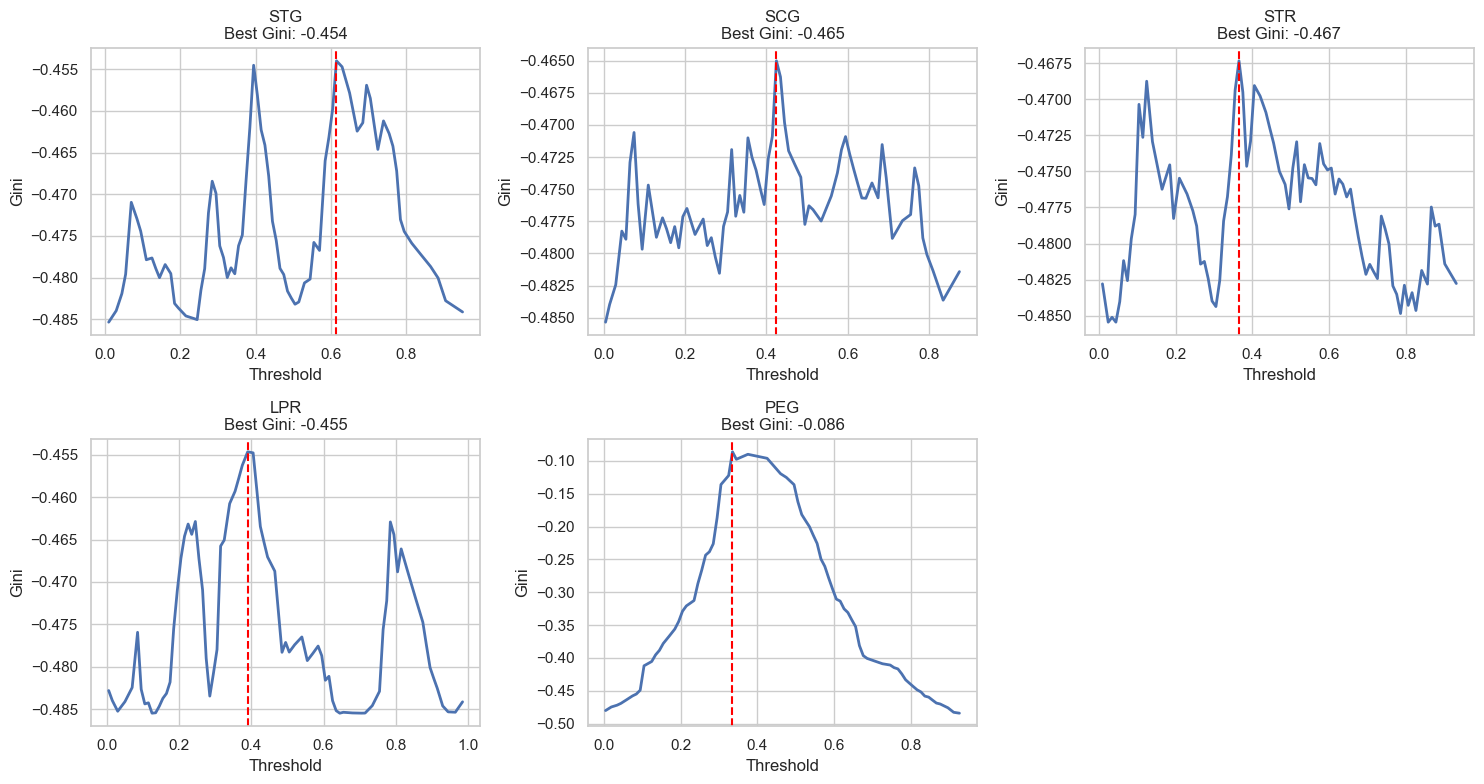

In [39]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from hw2code import find_best_split
students = pd.read_csv('students.csv')
features = ['STG', 'SCG', 'STR', 'LPR', 'PEG']
X = students[features]
y = students['UNS']

plt.figure(figsize=(15, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    plt.scatter(X[feature], y, alpha=0.7)
    plt.xlabel(feature)
    plt.ylabel('Class')
    plt.title(f'{feature} vs Class')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
for i, feature in enumerate(features):
    feature_vector = X[feature].values
    target_vector = y.values
    
    thresholds, ginis, best_threshold, best_gini = find_best_split(feature_vector, target_vector)
    
    plt.subplot(2, 3, i+1)
    if len(thresholds) > 0:
        plt.plot(thresholds, ginis, linewidth=2)
        if best_threshold is not None:
            plt.axvline(x=best_threshold, color='red', linestyle='--')
    plt.xlabel('Threshold')
    plt.ylabel('Gini')
    plt.title(f'{feature}\nBest Gini: {best_gini:.3f}')
plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Лучшим признаком для разделения выборки является PEG. Это подтверждается как визуальной оценкой scatter-графиков, где видно четкое разделение классов. На кривой Джини для PEG наблюдается выраженный пик высотой около -0.10 при пороге 0.35, что свидетельствует о хорошей разделяющей способности.
Кривые для признаков, таких как PEG, имеют четко выраженный пик критерия Джини, что позволяет найти оптимальный порог для почти идеального разделения классов. В то время как  кривые других признаков более плоские или имеют множество мелких пиков, что говорит о невозможности найти единый эффективный порог разделения.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [45]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
mushrooms = pd.read_csv('agaricus-lepiota.data', header=None)

le = LabelEncoder()
mushrooms_encoded = mushrooms.apply(le.fit_transform)

X_mush = mushrooms_encoded.iloc[:, 1:].values
y_mush = mushrooms_encoded.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X_mush, y_mush, test_size=0.5, random_state=42)

dt_custom = DecisionTree(feature_types=['categorical'] * X_mush.shape[1])
dt_custom.fit(X_train, y_train)

y_pred = dt_custom.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 1.0000


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

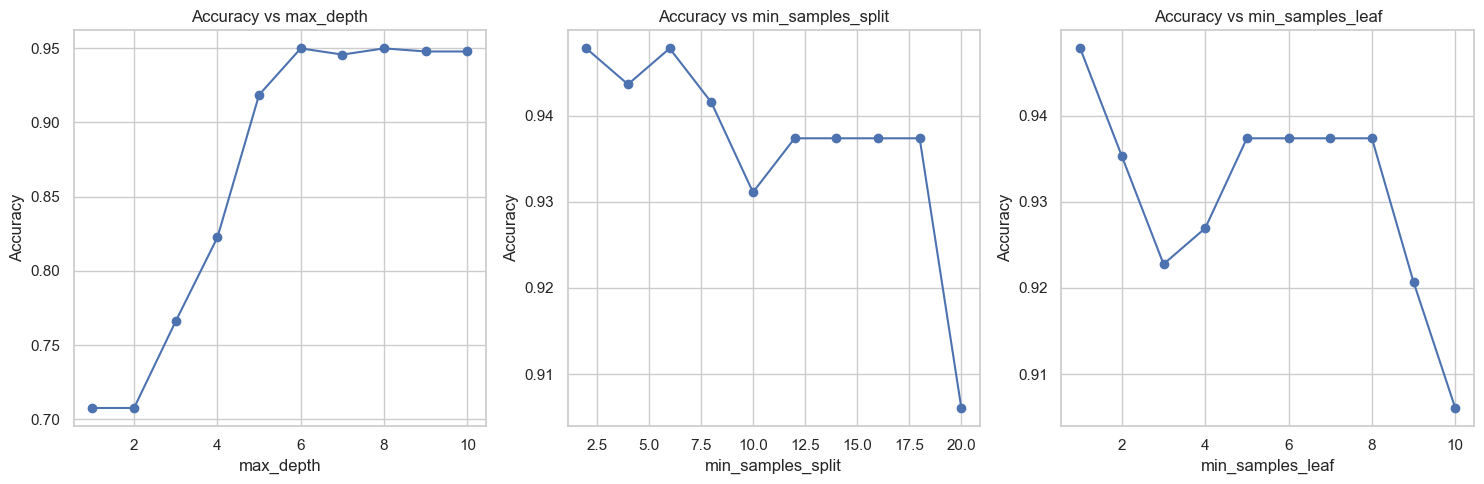

In [68]:

tic_tac_toe = pd.read_csv('tic-tac-toe-endgame.csv')

X = tic_tac_toe.iloc[:, :-1]
y = (tic_tac_toe.iloc[:, -1] == 'positive').astype(int)

le = LabelEncoder()
X_encoded = X.apply(le.fit_transform).values
y_encoded = y.values

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.5, random_state=42)

max_depths = range(1, 11)
min_samples_splits = range(2, 21, 2)
min_samples_leafs = range(1, 11)

acc_depth = []
for d in max_depths:
    tree = DecisionTree(['categorical'] * X_encoded.shape[1], max_depth=d)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    acc_depth.append(accuracy_score(y_test, y_pred))

acc_split = []
for s in min_samples_splits:
    tree = DecisionTree(['categorical'] * X_encoded.shape[1], min_samples_split=s)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    acc_split.append(accuracy_score(y_test, y_pred))

acc_leaf = []
for l in min_samples_leafs:
    tree = DecisionTree(['categorical'] * X_encoded.shape[1], min_samples_leaf=l)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    acc_leaf.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(max_depths, acc_depth, marker='o')
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs max_depth")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(min_samples_splits, acc_split, marker='o')
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.title("Accuracy vs min_samples_split")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(min_samples_leafs, acc_leaf, marker='o')
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.title("Accuracy vs min_samples_leaf")
plt.grid(True)

plt.tight_layout()
plt.show()

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [85]:
def evaluate_model_manual(model, X, y, cv=10, random_state=42):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = []
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model_clone = copy.deepcopy(model)
        model_clone.fit(X_train, y_train)
        y_pred = model_clone.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
    
    return np.mean(scores)

def load_mushrooms():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
    df = pd.read_csv(url, header=None)
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    le = LabelEncoder()
    X_encoded = X.apply(le.fit_transform)
    y_encoded = le.fit_transform(y)
    
    return X_encoded.values, y_encoded

def load_tic_tac_toe():
    print("Загрузка tic-tac-toe с UCI...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"
    df = pd.read_csv(url, header=None)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    
    le = LabelEncoder()
    X_encoded = X.apply(le.fit_transform)
    y_encoded = le.fit_transform(y)
    
    return X_encoded.values, y_encoded

def load_cars():
    print("Загрузка cars с UCI...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
    df = pd.read_csv(url, header=None)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    
    y_mapped = y.map({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1})
    y_encoded = y_mapped.values
    
    le = LabelEncoder()
    X_encoded = X.apply(le.fit_transform)
    
    return X_encoded.values, y_encoded

def load_nursery():
    print("Загрузка nursery с UCI...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
    df = pd.read_csv(url, header=None)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    
    y_mapped = y.map({'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1})
    y_encoded = y_mapped.values
    
    le = LabelEncoder()
    X_encoded = X.apply(le.fit_transform)
    
    return X_encoded.values, y_encoded

datasets = {}
try:
    X_m, y_m = load_mushrooms()
    datasets['mushrooms'] = (X_m, y_m)
    print(f"  mushrooms загружен: {X_m.shape}, {np.unique(y_m)}")
except Exception as e:
    print(f"Ошибка при загрузке mushrooms: {e}")

try:
    X_ttt, y_ttt = load_tic_tac_toe()
    datasets['tic-tac-toe'] = (X_ttt, y_ttt)
    print(f"  tic-tac-toe загружен: {X_ttt.shape}, {np.unique(y_ttt)}")
except Exception as e:
    print(f"Ошибка при загрузке tic-tac-toe: {e}")

try:
    X_c, y_c = load_cars()
    datasets['cars'] = (X_c, y_c)
    print(f"  cars загружен: {X_c.shape}, {np.unique(y_c)}")
except Exception as e:
    print(f"Ошибка при загрузке cars: {e}")

try:
    X_n, y_n = load_nursery()
    datasets['nursery'] = (X_n, y_n)
    print(f"  nursery загружен: {X_n.shape}, {np.unique(y_n)}")
except Exception as e:
    print(f"Ошибка при загрузке nursery: {e}")

if not datasets:
    raise ValueError("Ни один из датасетов не был успешно загружен.")

results_df = pd.DataFrame(columns=[
    'Dataset',
    'DT_real',
    'DT_cat', 
    'DT_real_ohe',
    'Sklearn_DT'
])

for dataset_name, (X, y) in datasets.items():
    print(f"\nОбработка датасета: {dataset_name}")
    
    dataset_results = {'Dataset': dataset_name}
    
    try:
        print("  Оценка DecisionTree (real)...")
        tree_real = DecisionTree(feature_types=["real"] * X.shape[1])
        score_real = evaluate_model_manual(tree_real, X, y, cv=10)
        dataset_results['DT_real'] = score_real
        print(f"    Результат: {score_real:.6f}")
    except Exception as e:
        print(f"    Ошибка: {e}")
        dataset_results['DT_real'] = np.nan
    
    try:
        print("  Оценка DecisionTree (categorical)...")
        tree_cat = DecisionTree(feature_types=["categorical"] * X.shape[1])
        score_cat = evaluate_model_manual(tree_cat, X, y, cv=10)
        dataset_results['DT_cat'] = score_cat
        print(f"    Результат: {score_cat:.6f}")
    except Exception as e:
        print(f"    Ошибка: {e}")
        dataset_results['DT_cat'] = np.nan
    
    try:
        print("  Оценка DecisionTree (real + one-hot)...")
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_ohe = ohe.fit_transform(X)
        tree_real_ohe = DecisionTree(feature_types=["real"] * X_ohe.shape[1])
        score_real_ohe = evaluate_model_manual(tree_real_ohe, X_ohe, y, cv=10)
        dataset_results['DT_real_ohe'] = score_real_ohe
        print(f"    Результат: {score_real_ohe:.6f}")
    except Exception as e:
        print(f"    Ошибка: {e}")
        dataset_results['DT_real_ohe'] = np.nan
    
    try:
        print("  Оценка DecisionTreeClassifier (sklearn)...")
        tree_sklearn = DecisionTreeClassifier(random_state=42)
        
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        sklearn_scores = []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            tree_clone = DecisionTreeClassifier(random_state=42)
            tree_clone.fit(X_train, y_train)
            y_pred = tree_clone.predict(X_test)
            sklearn_scores.append(accuracy_score(y_test, y_pred))
        
        score_sklearn = np.mean(sklearn_scores)
        dataset_results['Sklearn_DT'] = score_sklearn
        print(f"    Результат: {score_sklearn:.6f}")
    except Exception as e:
        print(f"    Ошибка: {e}")
        dataset_results['Sklearn_DT'] = np.nan
    
    results_df = pd.concat([results_df, pd.DataFrame([dataset_results])], ignore_index=True)

print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ:")
print(results_df.round(6))

  mushrooms загружен: (8124, 22), [0 1]
Загрузка tic-tac-toe с UCI...
  tic-tac-toe загружен: (958, 9), [0 1]
Загрузка cars с UCI...
  cars загружен: (1728, 6), [0 1]
Загрузка nursery с UCI...
  nursery загружен: (12960, 8), [0 1]

Обработка датасета: mushrooms
  Оценка DecisionTree (real)...
    Результат: 1.000000
  Оценка DecisionTree (categorical)...
    Результат: 1.000000
  Оценка DecisionTree (real + one-hot)...
    Результат: 1.000000
  Оценка DecisionTreeClassifier (sklearn)...
    Результат: 1.000000

Обработка датасета: tic-tac-toe
  Оценка DecisionTree (real)...
    Результат: 0.878947
  Оценка DecisionTree (categorical)...
    Результат: 0.942632
  Оценка DecisionTree (real + one-hot)...
    Результат: 0.938443
  Оценка DecisionTreeClassifier (sklearn)...
    Результат: 0.888355

Обработка датасета: cars
  Оценка DecisionTree (real)...
    Результат: 0.991891
  Оценка DecisionTree (categorical)...
    Результат: 0.991894
  Оценка DecisionTree (real + one-hot)...
    Резуль

__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

SyntaxError: invalid syntax (1906444692.py, line 1)

**Ответ:** Эффективность алгоритмов сильно зависит от природы данных - для категориальных признаков специализированные методы показывают лучшие результаты, в то время как на простых данных различия минимальны.
Ранжирование алгоритмов значительно различается между датасетами, что обусловлено их структурой и природой признаков.

Mushrooms: Все алгоритмы показывают идеальную точность (1.000), что свидетельствует о линейной разделимости данных и наличии четких правил классификации. Категориальные признаки идеально описывают закономерности.

Tic-Tac-Toe: Наиболее заметны различия - категориальные деревья (0.943) значительно превосходят вещественные (0.879). Это объясняется дискретной природой игровых позиций, где категориальное представление сохраняет семантику ходов.

Cars: Все подходы демонстрируют схожую высокую точность (~0.991), что указывает на простую структуру данных с явными закономерностями. One-hot encoding незначительно ухудшает результаты из-за избыточной размерности.

Nursery: Категориальные методы (0.9998) незначительно, но стабильно превосходят вещественные (0.9997), что связано с сохранением порядковых отношений между категориями.

Компонента случайности присутствует в разбиении данных и порядке обработки признаков. Для улучшения стабильности можно:

Использовать стратифицированную кросс-валидацию

Усреднять результаты по нескольким random_state

Настраивать гиперпараметры для каждого датасета

Вставьте что угодно, описывающее ваши впечатления от этого задания: